In [8]:
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import sys
from models.UNet.UNet import UNet
sys.path.insert(0, '../shared/')
from data_generator import DataGenerator
from predict import Predict

In [13]:
json_file = open('../config/config.json')
data = json.load(json_file)

# Splits training and testing data then gets corresponding files based on similar file names
dataset_path = data['DATASET_PATH'] + 'Night/'

validation_rgb = list(Path(dataset_path + 'RGB/Night_Validation').glob('*.png'))
validation_annotated = list(Path(dataset_path + 'Annotated/Validation').glob('*_gt_labelColor.png'))

# Splits training and testing data then gets corresponding files based on similar file names
training_rgb, test_rgb = train_test_split(list(Path(dataset_path + 'RGB/Night_Train').glob('*.png')), test_size=0.1)
training_annotated = [y for x in training_rgb for y in
                      list(Path(dataset_path + 'Annotated/Train').glob('*_gt_labelColor.png'))
                      if x.name.strip('_rgb_anon.png') == y.name.strip('_gt_labelColor.png')]
test_annotated = [y for x in test_rgb for y in list(Path(dataset_path + 'Annotated/Train').glob('*_gt_labelColor.png'))
                  if x.name.strip('_rgb_anon.png') == y.name.strip('_gt_labelColor.png')]

In [14]:
# [(image, annotated image)]
training_duo = [(x, y) for x, y in zip(training_rgb, training_annotated)]
testing_duo = [(x, y) for x, y in zip(test_rgb, test_annotated)]
validation_duo = [(x, y) for x, y in zip(validation_rgb, validation_annotated)]
image_size = (256, 256)

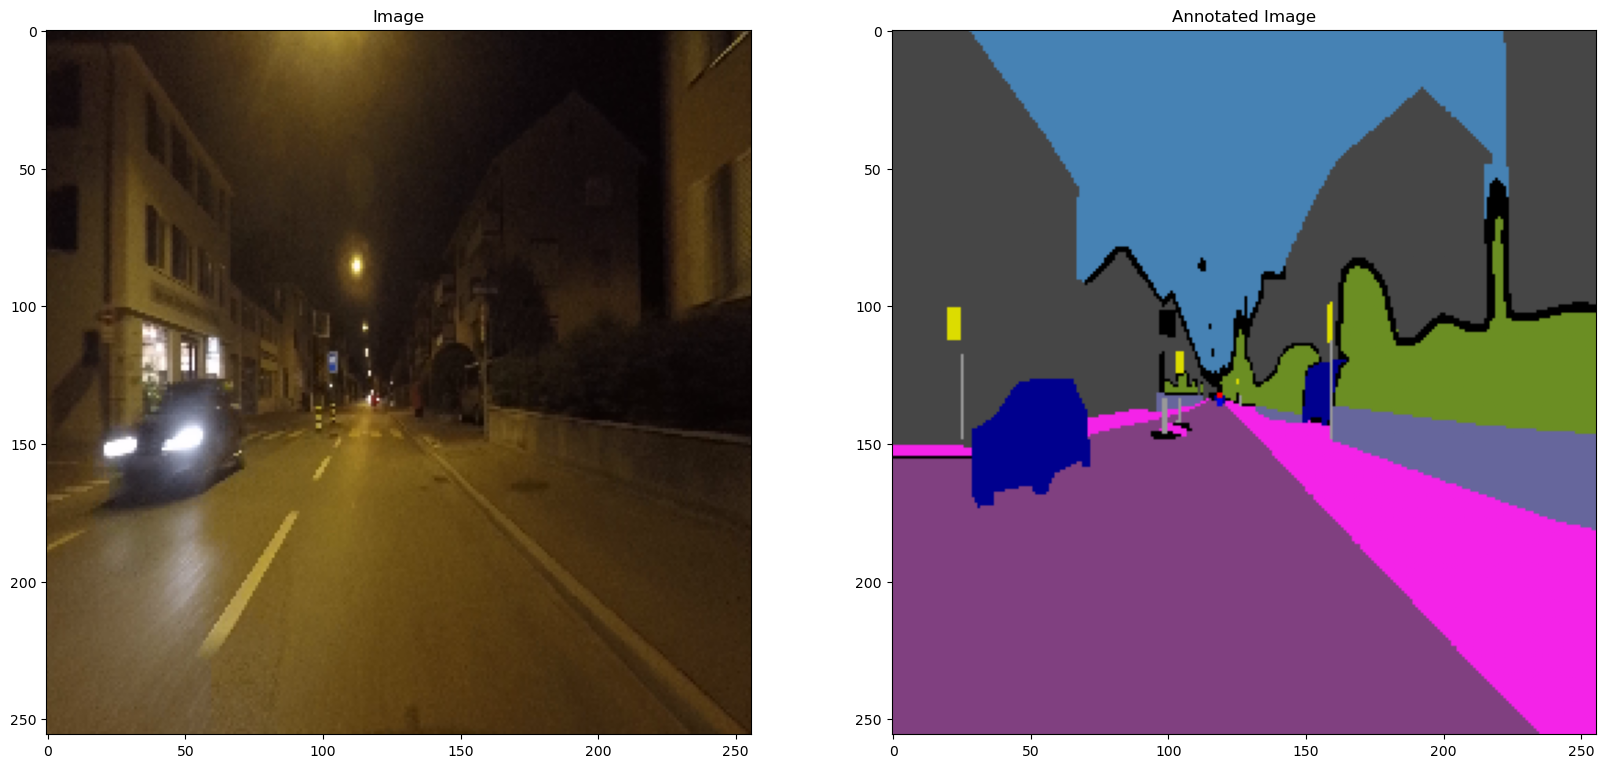

In [15]:
random_duo = training_duo[0]
image = img_to_array(load_img(random_duo[0], target_size=image_size))
annotated_image = img_to_array(load_img(random_duo[1], target_size =image_size))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(20)
fig.set_figwidth(20)
ax1.set_title('Image')
ax1.imshow(image / 255.)
ax2.set_title('Annotated Image')
ax2.imshow(annotated_image / 255.)

In [16]:
image_size = (256, 256)
classes_df = pd.read_csv(data['CLASS_PATH'])
classes = []
for index, item in classes_df.iterrows():
    classes.append(np.array([item['r'], item['g'], item['b']]))
num_classes = len(classes)

In [17]:
model = UNet(image_size, 3, 64, num_classes).model

In [18]:
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 512)  2359808     ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_2 (Dropout)            (None, 32, 32, 512)  0           ['batch_normalization_11[0][0]'] 
          

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])
# To load previously trained model
# model.load_weights('./night-weights.h5')

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

my_callbacks = [
    CSVLogger("./models/UNet/logs/log.csv", separator=",", append=False),
    ModelCheckpoint(filepath='./models/UNet/night-weights.h5', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    TensorBoard(log_dir='./models/UNet/logs')
]

In [13]:
training_data = DataGenerator(training_duo+testing_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True)
training_steps = training_data.__len__()

In [14]:
validation_data = DataGenerator(validation_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True)
validation_steps = validation_data.__len__()

In [15]:
model_train = model.fit(training_data, epochs=100, callbacks=my_callbacks, validation_data=validation_data, steps_per_epoch=training_steps, validation_steps=validation_steps)

Epoch 1/100
133/133 [==============================] - 72s 479ms/step - loss: 1.6095 - accuracy: 0.5318 - val_loss: 60.6362 - val_accuracy: 0.1272
Epoch 2/100
133/133 [==============================] - 44s 326ms/step - loss: 1.2036 - accuracy: 0.5999 - val_loss: 11.0432 - val_accuracy: 0.3352
Epoch 3/100
133/133 [==============================] - 43s 322ms/step - loss: 1.1147 - accuracy: 0.6168 - val_loss: 2.3399 - val_accuracy: 0.4533
Epoch 4/100
133/133 [==============================] - 43s 319ms/step - loss: 1.0609 - accuracy: 0.6330 - val_loss: 1.3726 - val_accuracy: 0.5939
Epoch 5/100
133/133 [==============================] - 42s 315ms/step - loss: 1.0158 - accuracy: 0.6417 - val_loss: 1.3451 - val_accuracy: 0.5932
Epoch 6/100
133/133 [==============================] - 43s 322ms/step - loss: 0.9974 - accuracy: 0.6480 - val_loss: 1.2619 - val_accuracy: 0.6169
Epoch 7/100
133/133 [==============================] - 42s 316ms/step - loss: 0.9609 - accuracy: 0.6625 - val_loss: 1.4103

Epoch 57/100
133/133 [==============================] - 46s 344ms/step - loss: 0.3089 - accuracy: 0.8905 - val_loss: 0.9779 - val_accuracy: 0.7331
Epoch 58/100
133/133 [==============================] - 43s 320ms/step - loss: 0.2916 - accuracy: 0.8961 - val_loss: 1.0301 - val_accuracy: 0.7016
Epoch 59/100
133/133 [==============================] - 42s 316ms/step - loss: 0.2835 - accuracy: 0.8992 - val_loss: 0.9905 - val_accuracy: 0.7258
Epoch 60/100
133/133 [==============================] - 43s 320ms/step - loss: 0.2750 - accuracy: 0.9016 - val_loss: 1.0369 - val_accuracy: 0.6964
Epoch 61/100
133/133 [==============================] - 42s 318ms/step - loss: 0.2667 - accuracy: 0.9048 - val_loss: 1.0044 - val_accuracy: 0.7189
Epoch 62/100
133/133 [==============================] - 43s 320ms/step - loss: 0.2652 - accuracy: 0.9054 - val_loss: 1.0844 - val_accuracy: 0.7082
Epoch 63/100
133/133 [==============================] - 45s 340ms/step - loss: 0.2769 - accuracy: 0.9020 - val_loss: 1

In [19]:
prediction = Predict(image_size, model, classes)

1/1 [==============================] - 0s 16ms/step


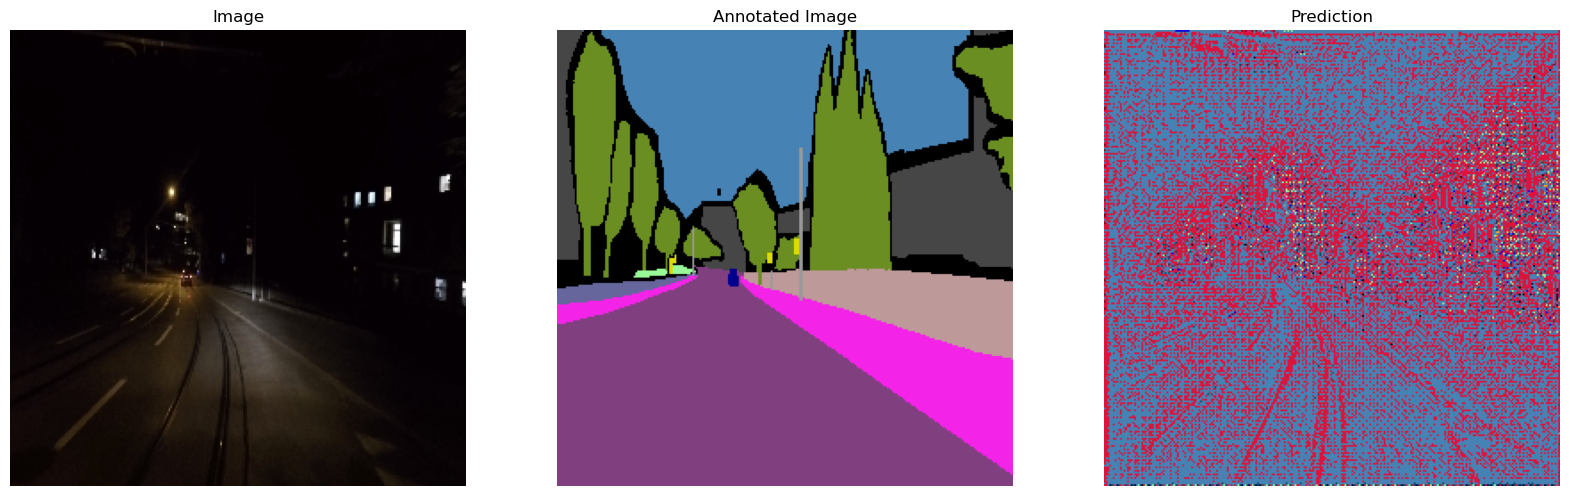

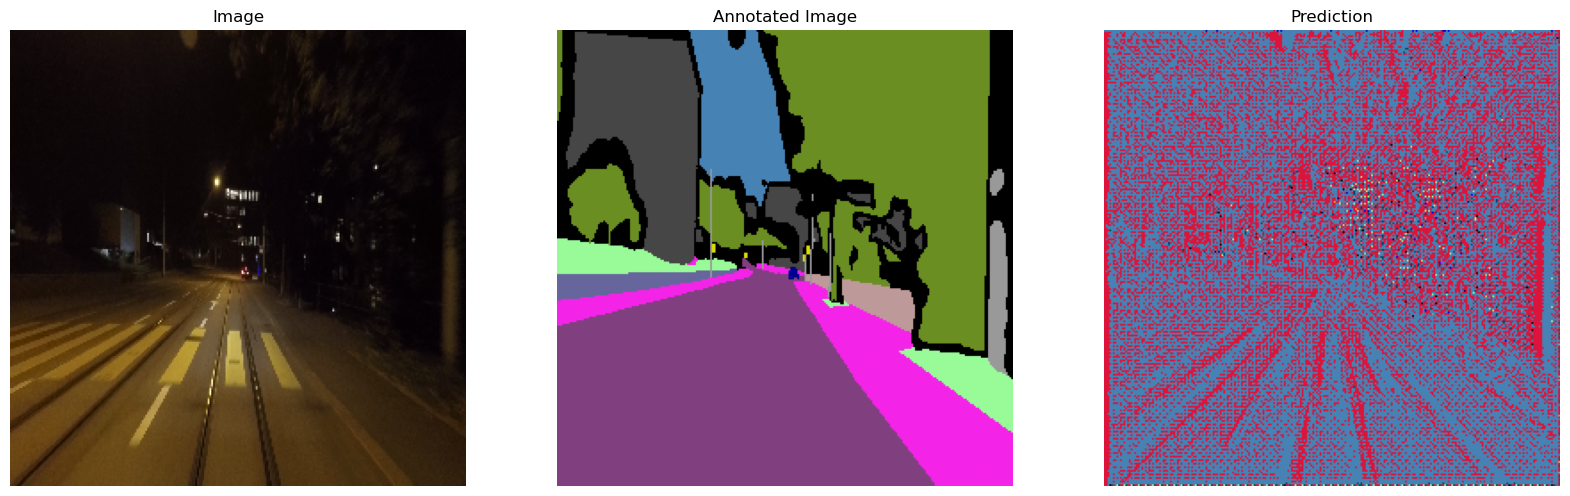

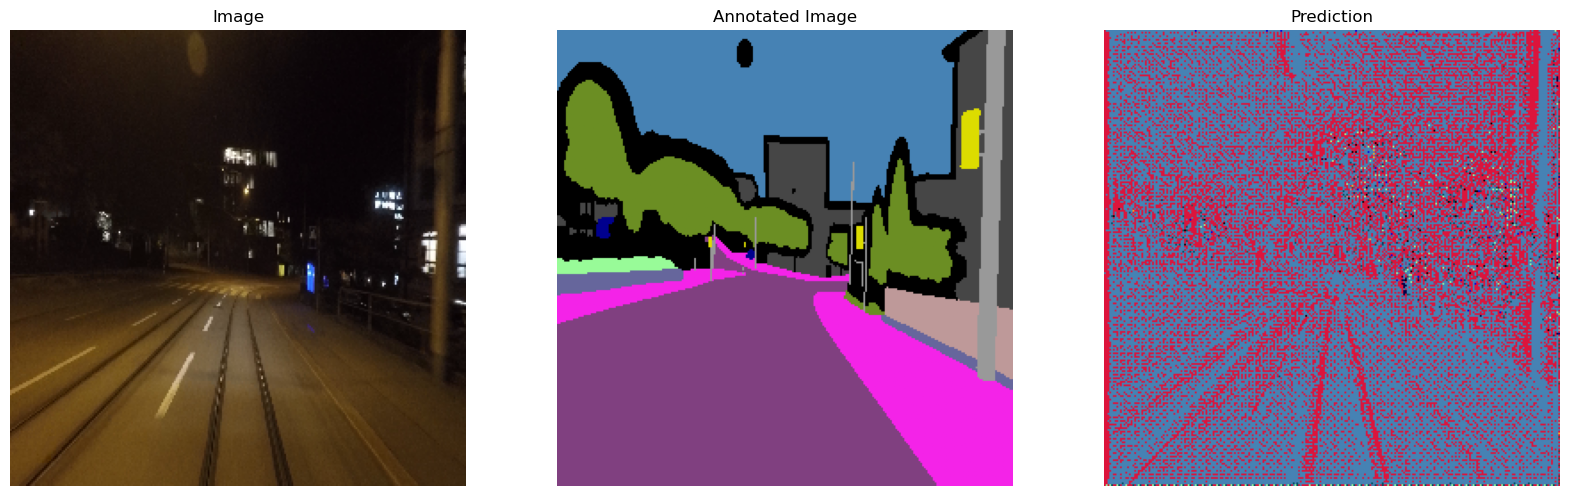

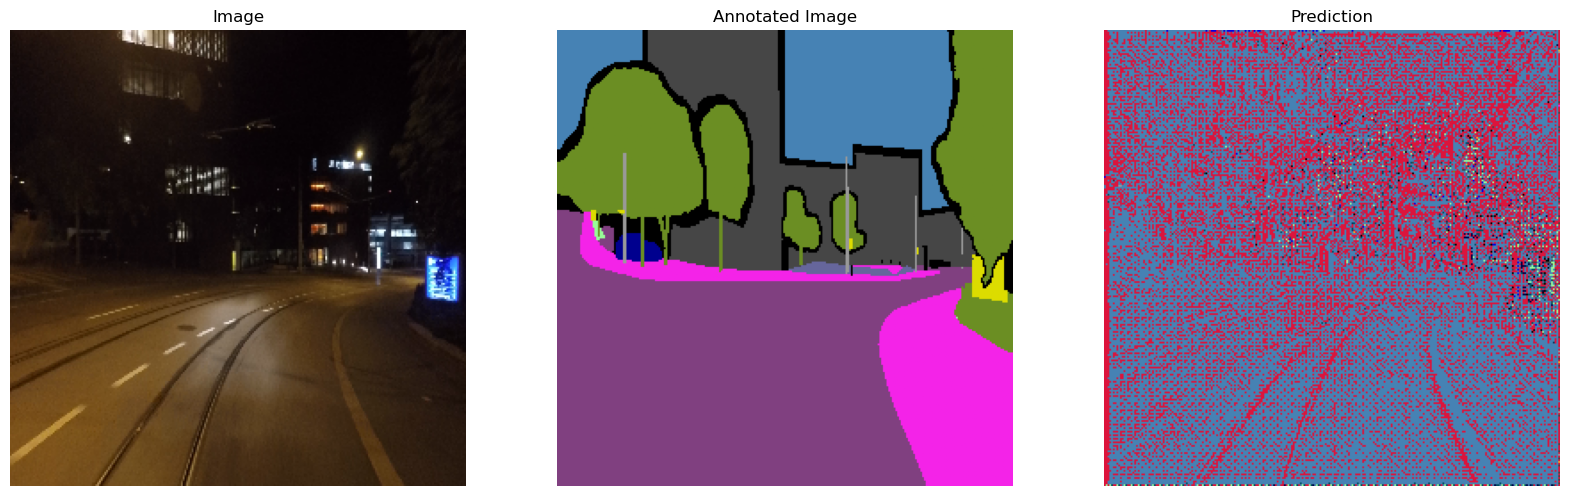

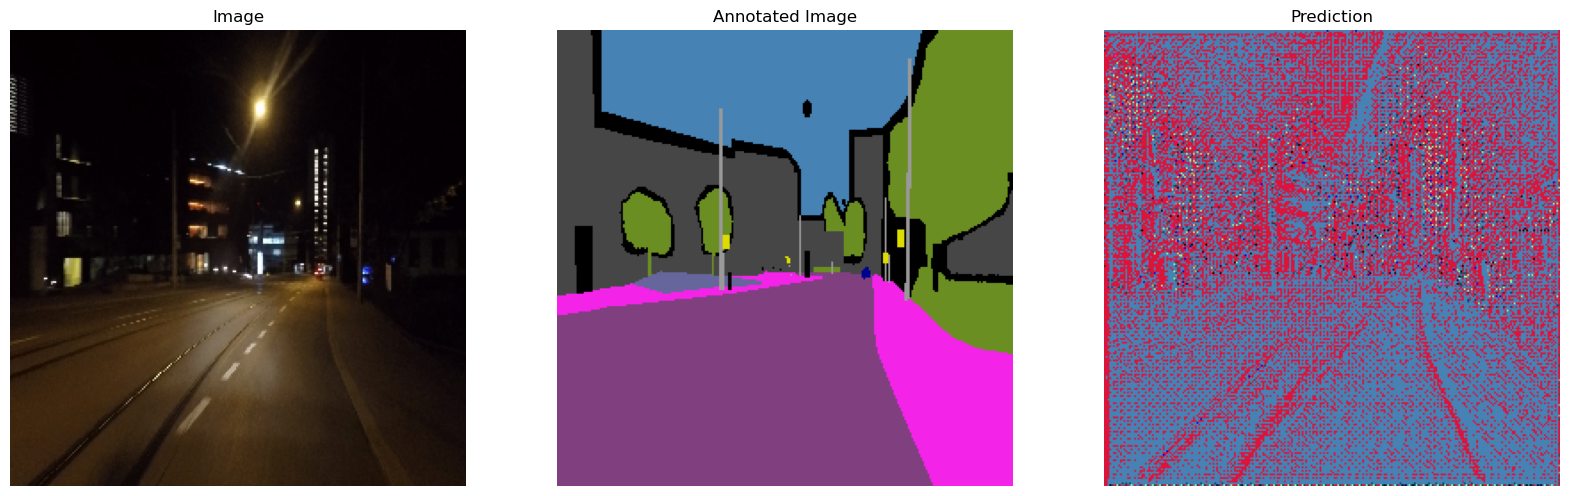

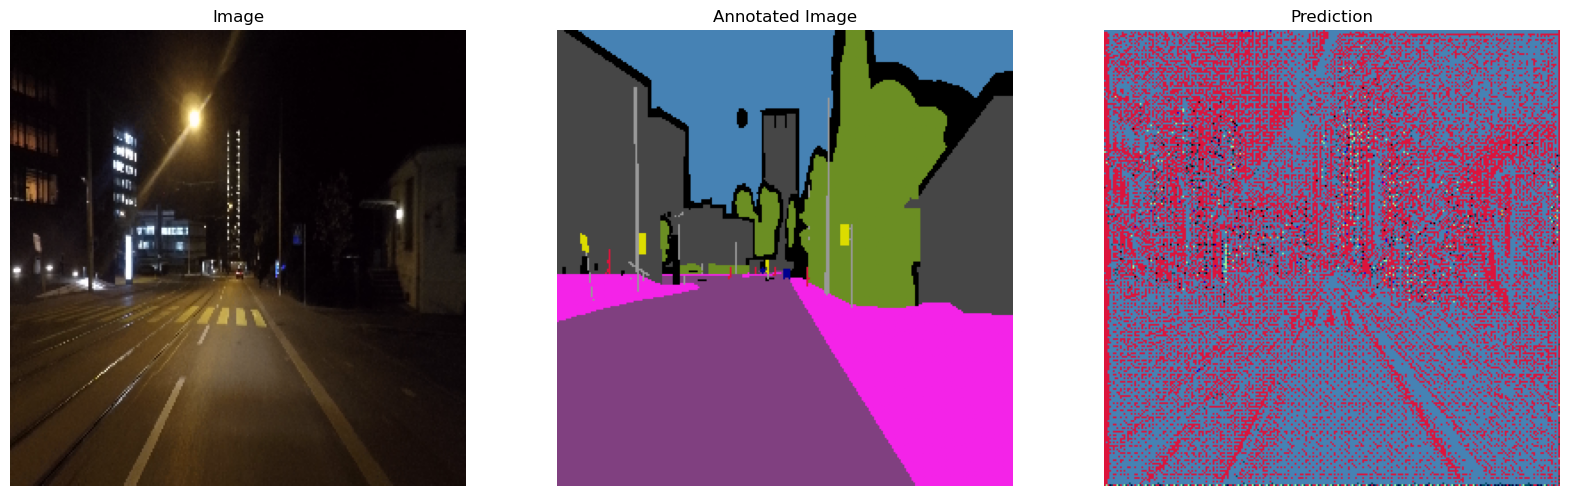

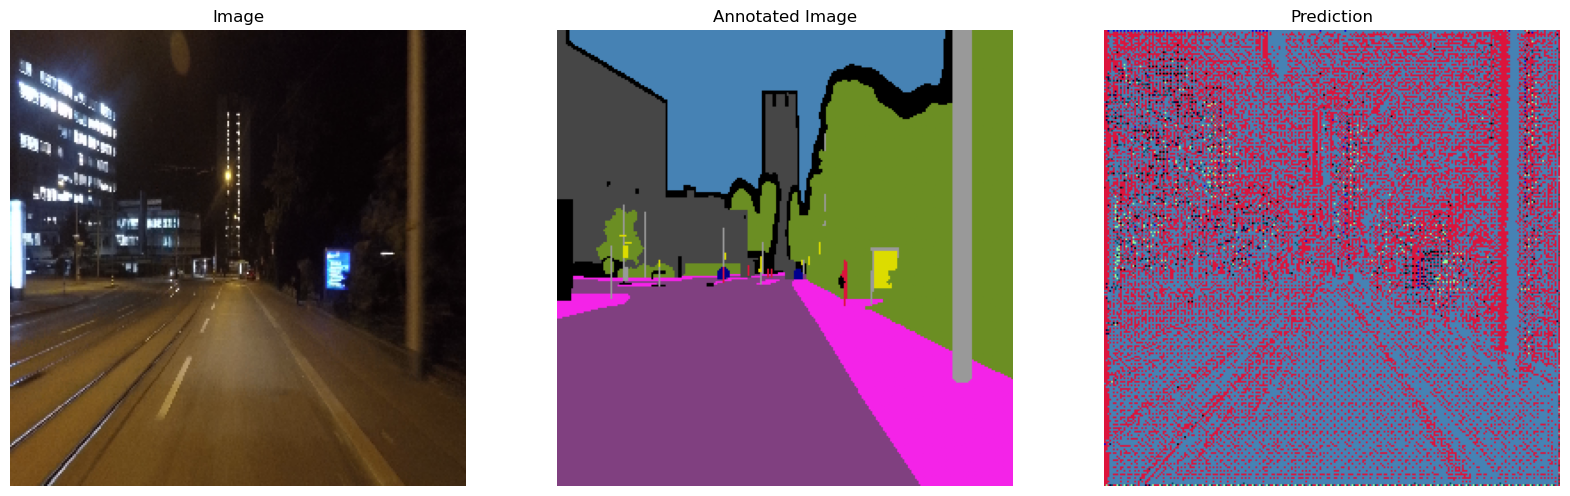

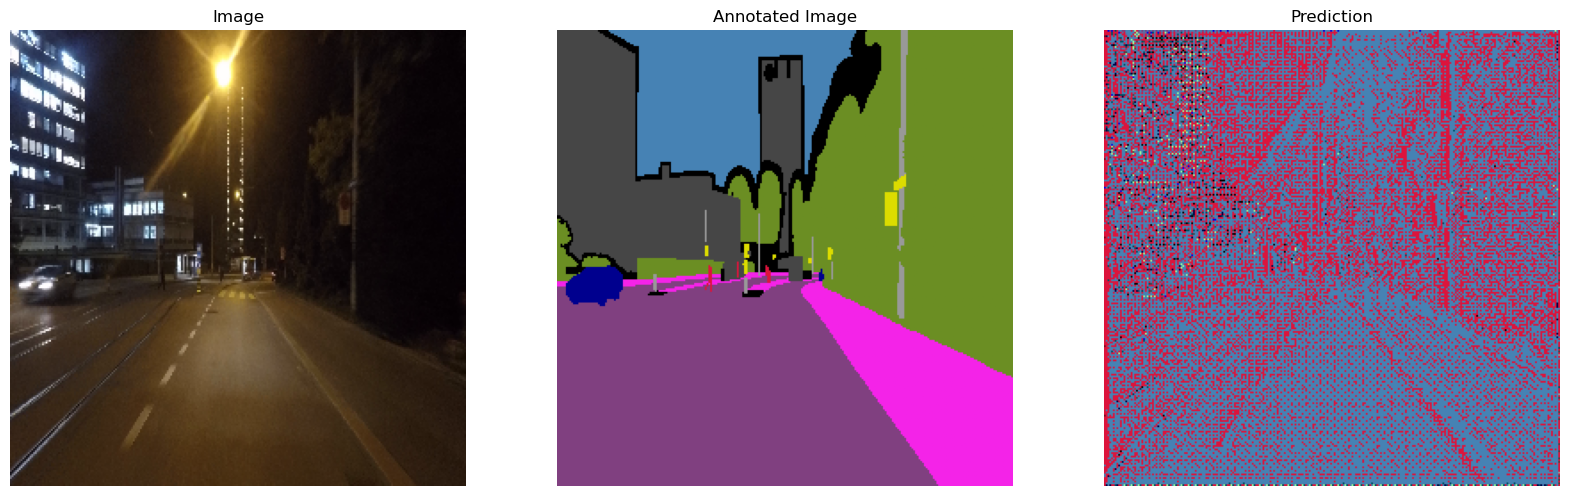

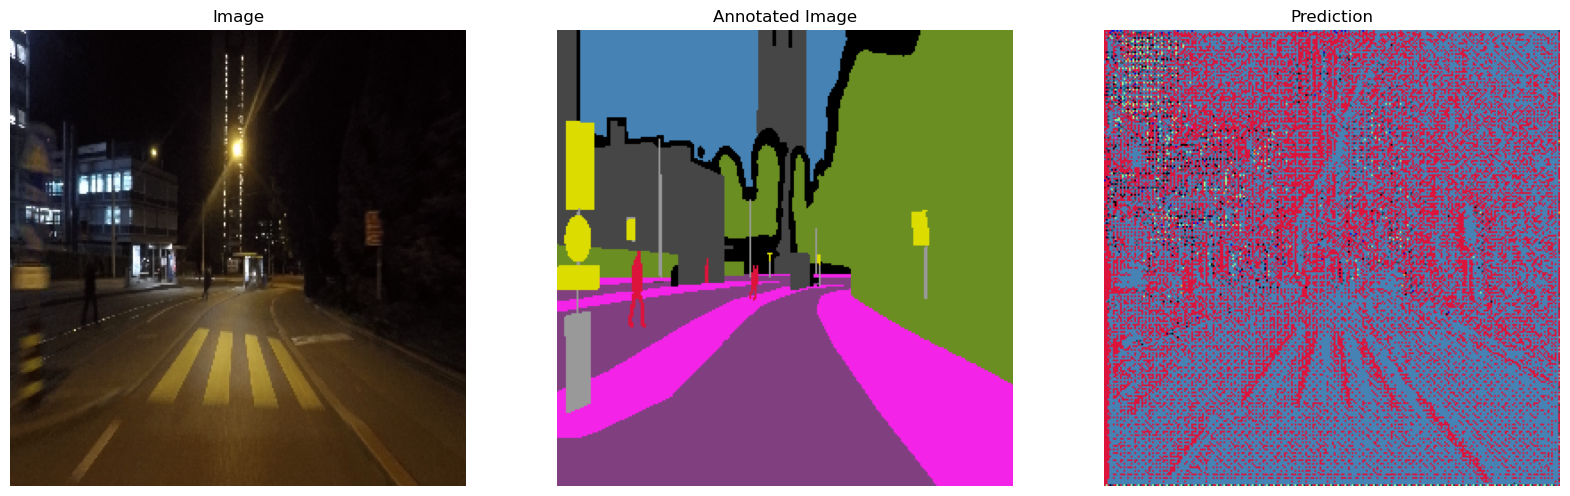

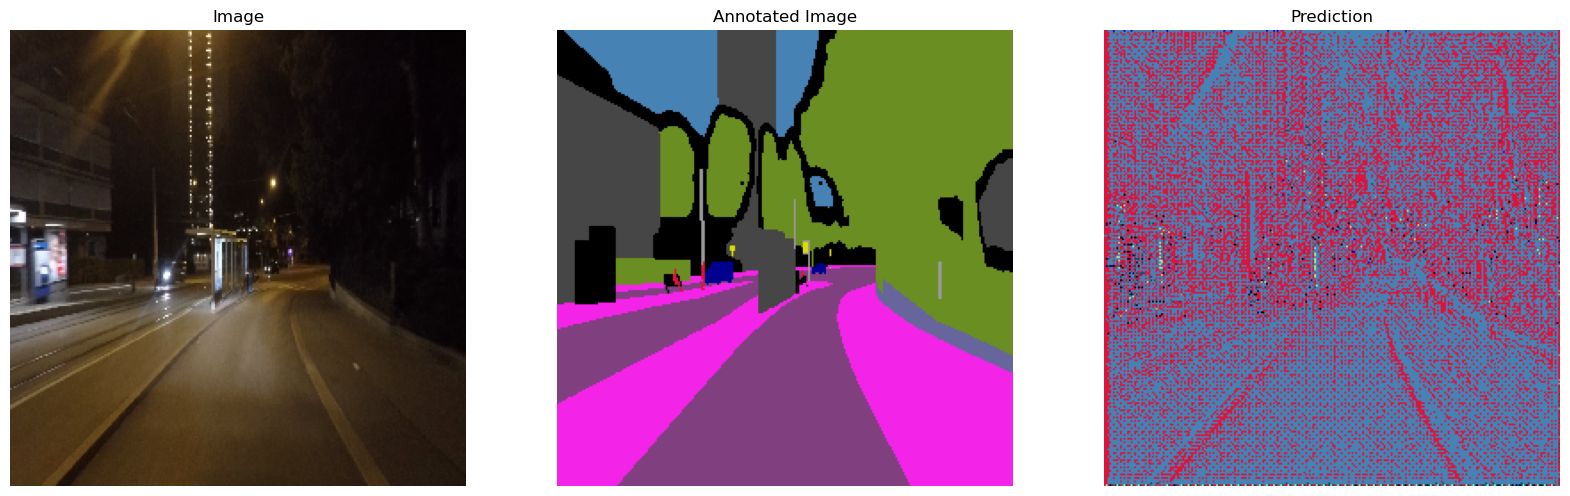

In [20]:
for x in range(0, 10):
    prediction.predict(validation_duo[x])